In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
calendar = pd.read_csv("data" + os.sep + "calendar_detail.csv")

In [3]:
# 总统计条目
calendar.shape

(10384980, 7)

In [5]:
# 房源数量
len(set(calendar["listing_id"]))

28452

In [6]:
calendar.describe()

listing_id  minimum_nights  maximum_nights
count  1.038498e+07    1.038462e+07    1.038462e+07
mean   2.628583e+07    2.728788e+00    3.611298e+04
std    6.403200e+06    1.754409e+01    5.928479e+06
min    4.405400e+04    1.000000e+00    1.000000e+00
25%    2.245616e+07    1.000000e+00    1.125000e+03
50%    2.787765e+07    1.000000e+00    1.125000e+03
75%    3.134482e+07    1.000000e+00    1.125000e+03
max    3.395441e+07    1.125000e+03    1.000000e+09

In [7]:
calendar.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

### 数据格式转换

In [8]:
calendar["date"] = calendar["date"].map(lambda d: datetime.datetime.strptime(d, "%Y-%m-%d"))

In [9]:
calendar["available"] = calendar["available"].map(lambda w: True if str(w) == 't' else False)

In [10]:
# 所有的价格以美元为单位， 所以可以拿去这个单位，而统一使用数值
set(calendar['adjusted_price'].map(lambda s: str(s)[0]))

{'$'}

In [11]:
calendar["price"] = calendar["price"].map(lambda s: float(str(s).replace(",", "")[1:]))
calendar["adjusted_price"] = calendar["adjusted_price"].map(lambda s: float(str(s).replace(",", "")[1:]))

In [12]:
calendar.dtypes

listing_id                 int64
date              datetime64[ns]
available                   bool
price                    float64
adjusted_price           float64
minimum_nights           float64
maximum_nights           float64
dtype: object

In [13]:
# calendar.describe()
calendar.sample(5)

listing_id       date  available  price  adjusted_price  \
4123533    25923568 2020-02-02      False  229.0           229.0   
1621192    19693645 2019-04-30      False  880.0           880.0   
2098380    21120767 2020-01-12      False   88.0            88.0   
1663264    20017035 2019-12-08       True  456.0           456.0   
1764055    20215194 2020-02-21      False  588.0           588.0   

         minimum_nights  maximum_nights  
4123533             1.0          1125.0  
1621192             2.0            30.0  
2098380             1.0          1125.0  
1663264             2.0           365.0  
1764055             2.0          1125.0

### 宏观分析，针对整体的时间趋势

In [20]:
# 按照日期分组，观察每天的非空房率
#（非空房原因：房间已经被预定，房东设置该房当天不可预定）
grouped = calendar.groupby(["date"])
date_df = pd.DataFrame( columns = ["listing_num", 
                                   "ava_num", "not_ava_num",
                                   "not_ava_rate", "ava_rate"])

for date, group in grouped:
    listing_num = group.shape[0]
    avail = group[group["available"] == True].shape[0]
    not_avail = group[group["available"] == False].shape[0]
    not_ava_rate = not_avail / (avail + not_avail)
    ava_rate = avail / (avail + not_avail)
#     print(date, listing_num, avail, not_avail, not_ava_rate)
    date_df.loc[date] = [listing_num, avail, not_avail, 
                         not_ava_rate, ava_rate]

In [22]:
date_df.sample(5)

listing_num  ava_num  not_ava_num  not_ava_rate  ava_rate
2020-01-29      28452.0  14317.0      14135.0      0.496802  0.503198
2019-08-01      28452.0  18509.0       9943.0      0.349466  0.650534
2020-04-14      28452.0  14276.0      14176.0      0.498243  0.501757
2019-11-12      28452.0  14415.0      14037.0      0.493357  0.506643
2020-01-12      28452.0  14608.0      13844.0      0.486574  0.513426

In [56]:
date_df.shape

(365, 5)

#### 由下图做线可得， 时间节点 2019.7.16 突然升高至0.35，时间节点 2019.10.14 升高至0.49左右

In [53]:
def plt_vs_time(start_date = None, end_date = None):
    plt.clf()
    print(start_date, end_date)
    start_index = date_df[date_df.index <= start_date ].shape[0] if isinstance(start_date, datetime.datetime) else 0
    end_index = date_df[date_df.index <= end_date ].shape[0] if isinstance(end_date, datetime.datetime) else -1
    print(start_index, end_index)
    plt.plot(date_df.index[start_index:end_index], date_df["not_ava_rate"][start_index:end_index])
    plt.xticks(rotation = 50)
    plt.show()

None None
0 -1


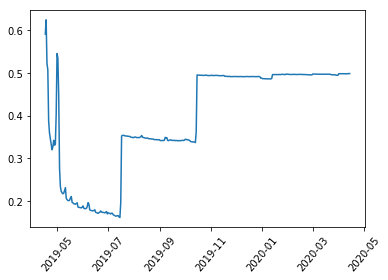

In [54]:
plt_vs_time()

2019-04-17 00:00:00 2019-07-16 00:00:00
1 91


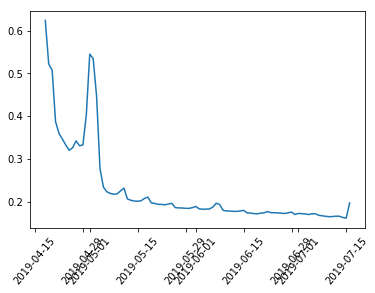

In [57]:
start_date = datetime.datetime(2019, 4, 17)
end_date = datetime.datetime(2019, 7, 16)
plt_vs_time(start_date = start_date, end_date = end_date)

2019-07-16 00:00:00 2019-10-13 00:00:00
91 180


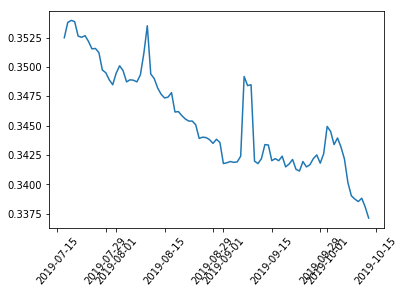

In [59]:
start_date = datetime.datetime(2019, 7, 16)
end_date = datetime.datetime(2019, 10, 13)
plt_vs_time(start_date = start_date, end_date = end_date)

2019-10-14 00:00:00 2020-10-13 00:00:00
181 365


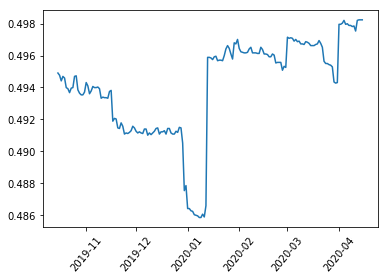

In [60]:
start_date = datetime.datetime(2019, 10, 14)
end_date = datetime.datetime(2020, 10, 13)
plt_vs_time(start_date = start_date, end_date = end_date)

In [81]:
start = datetime.datetime(2019, 4, 17)
end_1 = datetime.datetime(2019, 7, 16)
end_2 = datetime.datetime(2019, 10, 14)
print((end_1 - start).days)
print((end_2 - start).days)

90
180


#### 由以上计算推测airbnb可由房东设置近N天内开放预定，由两个时间节点90天与180天

### 微观分析，针对个别的时间趋势

In [8]:
calendar[calendar["minimum_nights"] != 1]

listing_id        date available    price adjusted_price  \
1095        10532616  2019-04-17         t   $98.00         $98.00   
1096        10532616  2019-04-18         f   $98.00         $98.00   
1097        10532616  2019-04-19         f  $108.00        $108.00   
1098        10532616  2019-04-20         f  $108.00        $108.00   
1099        10532616  2019-04-21         f   $98.00         $98.00   
1100        10532616  2019-04-22         f   $98.00         $98.00   
1101        10532616  2019-04-23         f   $98.00         $98.00   
1102        10532616  2019-04-24         f   $98.00         $98.00   
1103        10532616  2019-04-25         f   $98.00         $98.00   
1104        10532616  2019-04-26         f  $108.00        $108.00   
1105        10532616  2019-04-27         f  $108.00        $108.00   
1106        10532616  2019-04-28         f   $98.00         $98.00   
1107        10532616  2019-04-29         f   $98.00         $98.00   
1108        10532616  2019-04-30         f   $98.00         $98.00   
1109        10532616  2019-05-01         f   $98.00         $98.00   
1110        10532616  2019-05-02         f   $98.00         $98.00   
1111        10532616  2019-05-03         f  $108.00        $108.00   
1112        10532616  2019-05-04         f  $108.00        $108.00   
1113        10532616  2019-05-05         f   $98.00         $98.00   
1114        10532616  2019-05-06         f   $98.00         $98.00   
1115        10532616  2019-05-07         f   $98.00         $98.00   
1116        10532616  2019-05-08         f   $98.00         $98.00   
1117        10532616  2019-05-09         f   $98.00         $98.00   
1118        10532616  2019-05-10         f  $108.00        $108.00   
1119        10532616  2019-05-11         f  $108.00        $108.00   
1120        10532616  2019-05-12         f   $98.00         $98.00   
1121        10532616  2019-05-13         f   $98.00         $98.00   
1122        10532616  2019-05-14         f   $98.00         $98.00   
1123        10532616  2019-05-15         f   $98.00         $98.00   
1124        10532616  2019-05-16         f   $98.00         $98.00   
...              ...         ...       ...      ...            ...   
10383729    33665533  2020-03-17         f  $189.00        $189.00   
10383730    33665533  2020-03-18         f  $189.00        $189.00   
10383731    33665533  2020-03-19         f  $189.00        $189.00   
10383732    33665533  2020-03-20         f  $189.00        $189.00   
10383733    33665533  2020-03-21         f  $189.00        $189.00   
10383734    33665533  2020-03-22         f  $189.00        $189.00   
10383735    33665533  2020-03-23         f  $189.00        $189.00   
10383736    33665533  2020-03-24         f  $189.00        $189.00   
10383737    33665533  2020-03-25         f  $189.00        $189.00   
10383738    33665533  2020-03-26         f  $189.00        $189.00   
10383739    33665533  2020-03-27         f  $189.00        $189.00   
10383740    33665533  2020-03-28         f  $189.00        $189.00   
10383741    33665533  2020-03-29         f  $189.00        $189.00   
10383865    33665533  2020-03-30         f  $189.00        $189.00   
10383866    33665533  2020-03-31         f  $189.00        $189.00   
10383867    33665533  2020-04-01         f  $189.00        $189.00   
10383868    33665533  2020-04-02         f  $189.00        $189.00   
10383869    33665533  2020-04-03         f  $189.00        $189.00   
10383870    33665533  2020-04-04         f  $189.00        $189.00   
10383871    33665533  2020-04-05         f  $189.00        $189.00   
10383872    33665533  2020-04-06         f  $189.00        $189.00   
10383873    33665533  2020-04-07         f  $189.00        $189.00   
10383874    33665533  2020-04-08         f  $189.00        $189.00   
10383875    33665533  2020-04-09         f  $189.00        $189.00   
10383876    33665533  2020-04-10         f  $189.00        $189.00   
10383877    33665533

In [14]:
adjust_price_data = calendar[calendar["price"] != calendar["adjusted_price"]]
grouped = adjust_price_data.groupby(["listing_id"])

long_count = {}

for listing_id, group in grouped:
#     print(listing_id, group.shape[0])
    group_size = group.shape[0]
    if group_size in long_count:
        long_count[group_size] += 1
    else:
        long_count[group_size] = 1

# print(long_count)

{335: 27, 15: 2, 334: 75, 3: 102, 4: 30, 214: 1, 8: 6, 184: 1, 7: 8, 337: 51, 350: 1, 17: 5, 351: 11, 338: 3, 30: 1, 22: 6, 5: 36, 9: 13, 339: 13, 185: 1, 245: 1, 2: 48, 307: 11, 308: 3, 12: 3, 98: 1, 27: 1, 115: 1, 304: 6, 277: 6, 274: 4, 40: 4, 291: 1, 42: 1, 275: 1, 323: 1, 28: 6, 346: 4, 311: 4, 6: 5, 343: 15, 217: 1, 321: 1, 348: 1, 71: 1, 64: 1, 363: 1, 244: 1, 356: 3, 341: 6, 26: 1, 336: 1, 187: 1, 340: 1, 76: 1, 14: 1, 23: 1, 305: 1, 364: 7, 1: 1, 16: 1, 326: 1, 309: 1}


In [16]:
for i in sorted(long_count):
    print(i, long_count[i])

1 1
2 48
3 102
4 30
5 36
6 5
7 8
8 6
9 13
12 3
14 1
15 2
16 1
17 5
22 6
23 1
26 1
27 1
28 6
30 1
40 4
42 1
64 1
71 1
76 1
98 1
115 1
184 1
185 1
187 1
214 1
217 1
244 1
245 1
274 4
275 1
277 6
291 1
304 6
305 1
307 11
308 3
309 1
311 4
321 1
323 1
326 1
334 75
335 27
336 1
337 51
338 3
339 13
340 1
341 6
343 15
346 4
348 1
350 1
351 11
356 3
363 1
364 7


In [67]:
grouped = calendar.groupby(["date"])
date_df = pd.DataFrame( columns = ["num_price_adj", "num_price_adj_not_ava"])

for date, group in grouped:
    listing_num = group.shape[0]
    sub_group = group[group["price"] != group["adjusted_price"]]
    count_0 = sub_group.shape[0]
    count_1 = sub_group[sub_group["available"] == False].shape[0]
    date_df.loc[date] = [count_0, count_1]

In [68]:
date_df

num_price_adj num_price_adj_not_ava
2019-04-17           419                   343
2019-04-18           417                   316
2019-04-19           351                   243
2019-04-20           197                   124
2019-04-21           159                    68
2019-04-22           114                    46
2019-04-23           104                    36
2019-04-24            98                    31
2019-04-25            91                    28
2019-04-26            64                    19
2019-04-27            64                    24
2019-04-28            64                    26
2019-04-29            57                    26
2019-04-30            56                    29
2019-05-01            53                    34
2019-05-02            50                    32
2019-05-03            43                    20
2019-05-04            29                     8
2019-05-05            33                     8
2019-05-06            33                    11
2019-05-07            33                    12
2019-05-08            32                     9
2019-05-09            23                     5
2019-05-10            23                     5
2019-05-11            23                     7
2019-05-12            23                     7
2019-05-13            22                     4
2019-05-14            20                     3
2019-05-15            14                     3
2019-05-16             6                     4
...                  ...                   ...
2020-03-17           270                   139
2020-03-18           270                   139
2020-03-19           270                   139
2020-03-20           270                   139
2020-03-21           270                   139
2020-03-22           270                   139
2020-03-23           270                   139
2020-03-24           270                   139
2020-03-25           270                   139
2020-03-26           270                   139
2020-03-27           270                   139
2020-03-28           270                   139
2020-03-29           270                   139
2020-03-30           270                   139
2020-03-31           270                   139
2020-04-01           270                   139
2020-04-02           270                   139
2020-04-03           270                   139
2020-04-04           270                   139
2020-04-05           270                   139
2020-04-06           270                   139
2020-04-07           270                   139
2020-04-08           270                   139
2020-04-09           270                   139
2020-04-10           270                   139
2020-04-11           271                   139
2020-04-12           272                   139
2020-04-13           272                   139
2020-04-14           272                   139
2020-04-15           272                   139

[365 rows x 2 columns]

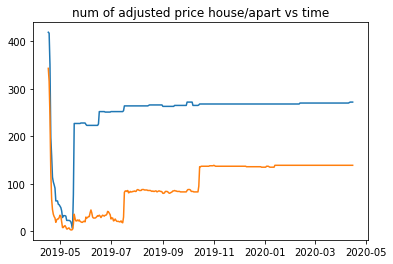

In [69]:
plt.clf()
plt.plot(date_df.index, date_df["num_price_adj"])
plt.plot(date_df.index, date_df["num_price_adj_not_ava"])
plt.title("num of adjusted price house/apart vs time")
plt.show()